In [ ]:
import pandas as pd
df = pd.read_csv("DATASET 1.csv")

In [ ]:
# Count the number of rows per category
category_counts = df['Category'].value_counts()

# Keep only categories with at least 30 rows
valid_categories = category_counts[category_counts >= 30].index
filtered_df = df[df['Category'].isin(valid_categories)]

# For categories with more than 100 rows, keep only the first 100
limited_df = filtered_df.groupby('Category').head(100)

# Save the filtered result
limited_df.to_csv("raw_dataset.csv", index=False)


In [ ]:
print("Final Balanced Dataset Shape:", limited_df.shape)
print("Categories and Counts:\n", limited_df['Category'].value_counts())


Final Balanced Dataset Shape: (3627, 2)
Categories and Counts:
 Category
Accountant                 100
Advocate                   100
Arts                       100
Banking                    100
Aviation                   100
Construction               100
Consultant                 100
Chef                       100
Business Development       100
Information Technology     100
Healthcare                 100
Database Administrator     100
Designer                   100
Education                  100
Engineering                100
Web Developer              100
Sales                      100
HR                         100
Fitness                    100
Finance                    100
Engineering                100
Security Analyst           100
Teacher                    100
Information Technology     100
Network Administrator      100
Project manager            100
Public Relations           100
Python Developer           100
Apparel                     97
Digital Media               

In [ ]:
df = limited_df

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# === Step 1: Initialize TF-IDF Vectorizer ===
tfidf_vectorizer = TfidfVectorizer(
    max_features=1200,      # Top 1200 most important words/phrases
    ngram_range=(1, 2),     # Unigrams + Bigrams
    min_df=5,               # Appear in at least 5 resumes
    max_df=0.8              # Appear in at most 80% of resumes
)

# === Step 2: Fit and Transform on balanced_df ===
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Resume'])

# === Step 3: Confirm Shape ===
print("TF-IDF Matrix Shape", tfidf_matrix.shape)


TF-IDF Matrix Shape (3627, 1200)


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def extract_structural_features(text_series):
    features = []

    for text in text_series:
        tokens = text.split()
        num_words = len(tokens)
        num_chars = sum(len(word) for word in tokens)
        avg_word_length = num_chars / num_words if num_words else 0

        num_digits = sum(char.isdigit() for char in text)
        num_uppercase_words = sum(word.isupper() for word in tokens)
        num_unique_words = len(set(tokens))
        num_stopwords = sum(1 for word in tokens if word.lower() in ENGLISH_STOP_WORDS)

        features.append([
            num_words,
            avg_word_length,
            num_digits,
            num_uppercase_words,
            num_unique_words,
            num_stopwords
        ])

    return np.array(features)

# === Extract features from balanced_df ===
structural_features = extract_structural_features(df['Resume'])

# === Wrap in a DataFrame ===
import pandas as pd
# Rename the structural features for balanced dataset
structural_df= pd.DataFrame(
    structural_features,
    columns=[
        'resume_length',
        'avg_word_length',
        'num_digits',
        'num_uppercase_words',
        'num_unique_words',
        'num_stopwords'
    ]
)


# === Check output ===
print(" Structural Feature Matrix Shape:", structural_df.shape)
print(" Sample Structural Features:\n", structural_df.head())


 Structural Feature Matrix Shape: (3627, 6)
 Sample Structural Features:
    resume_length  avg_word_length  num_digits  num_uppercase_words  \
0          747.0         6.402945        42.0                 26.0   
1         1224.0         6.159314       106.0                 31.0   
2         1049.0         5.924690        84.0                 23.0   
3          659.0         6.303490        65.0                 25.0   
4          675.0         6.082963       141.0                 32.0   

   num_unique_words  num_stopwords  
0             401.0          173.0  
1             673.0          329.0  
2             485.0          290.0  
3             372.0          127.0  
4             390.0          119.0  


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a lightweight, fast BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the resumes
bert_embeddings = bert_model.encode(df['Resume'].tolist(), show_progress_bar=True)

# Convert to dense array (no need for avg_glove_vector anymore)
semantic_vectors_balanced = np.array(bert_embeddings)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# === 1. Scale Structural Features ===
scaler_struct = StandardScaler()
struct_scaled_balanced = scaler_struct.fit_transform(structural_df)

# === 2. Scale Semantic Features ===
scaler_sem = StandardScaler()
semantic_scaled_balanced = scaler_sem.fit_transform(semantic_vectors_balanced)

# === 3. Convert to Sparse Matrices ===
struct_sparse_balanced = csr_matrix(struct_scaled_balanced)
semantic_sparse_balanced = csr_matrix(semantic_scaled_balanced)

# === 4. Stack TF-IDF + Structural + Semantic ===
X_np = hstack([
    tfidf_matrix,
    struct_sparse_balanced,
    semantic_sparse_balanced
])

# Final shape check
print("Final Feature Matrix Shape:", X_np.shape)



Final Feature Matrix Shape: (3627, 1590)


In [ ]:
# Convert sparse matrix to dense (if it's not too large)
X_dense = X_np.toarray()  # Use only if the data is small/medium size!


df['embedding'] = [vec.tolist() for vec in X_dense]

# Check the first embedding vector
print(df["embedding"][0])

[0.0, 0.09846995958632149, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019275457879396874, 0.03537841003054677, 0.0, 0.0, 0.0, 0.02805789750157089, 0.0, 0.0, 0.06207122899920598, 0.0, 0.0, 0.0, 0.0, 0.02568953058041774, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018269958849760733, 0.0, 0.0, 0.01782288634969645, 0.0, 0.02322732385926475, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.024281147525339178, 0.0, 0.0, 0.0, 0.0, 0.024809575965438556, 0.1561349275479466, 0.409360593521653, 0.07158602640335288, 0.05794284807787483, 0.027545409637908542, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03565510313425503, 0.0, 0.0, 0.0, 0.020571937502917713, 0.0, 0.0, 0.0, 0.0, 0.0, 0.027824767089117096, 0.0, 0.0, 0.0, 0.0, 0.03902838988074978, 0.0, 0.0, 0.0, 0.0, 0.030274140366317225, 0.030885127288150765, 0.0925748579823332, 0.059180022362145486, 0.0, 0.05629818979577493, 0.0, 0.05561413334068517, 0.0274427146478899, 0.0, 0.

<ipython-input-22-334bfa650a62>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embedding'] = [vec.tolist() for vec in X_dense]


In [ ]:
# Save the filtered result
df.to_csv("embedded_dataset.csv", index=False)

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# === 1. Initial split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_np,
    df['Category'],
    test_size=0.3,
    stratify=df['Category'],
    random_state=42
)

# === 3. Split Temp into Validation and Test (50/50)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Final size check
print("Train Shape:", X_train.shape)
print("Validation Shape:", X_val.shape)
print("Test Shape:", X_test.shape)


Train Shape: (2538, 1590)
Validation Shape: (544, 1590)
Test Shape: (545, 1590)


In [ ]:
from sklearn.cluster import KMeans

# Set the number of clusters (k) for KMeans
k = 30

# Initialize the KMeans clustering model
# - n_clusters: number of desired clusters
# - random_state: ensures reproducibility of results
# - n_init: number of times the algorithm will be run with different centroid seeds
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# Fit the KMeans model to the data and get cluster labels for each data point
clusters = kmeans.fit_predict(X_np)

# Add the cluster labels as a new column in the original DataFrame
df["Cluster"] = clusters

# Display the first few entries of the cleaned resumes along with their assigned cluster
df[["Resume", "Cluster"]].head()


<ipython-input-28-dd52fa991c64>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cluster"] = clusters


,Resume,Cluster
0,ACCOUNTANT Professional Summary Results orient...,4
1,STAFF ACCOUNTANT Summary Flexible Accountant w...,4
2,STAFF ACCOUNTANT Summary Highly analytical and...,4
3,SENIOR ACCOUNTANT Summary A highly competent m...,4
4,SENIOR ACCOUNTANT Summary 11 years experience ...,4


In [ ]:
# Elbow Method Example
inertias = []
K_range = range(1, 30)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_np)
    inertias.append(km.inertia_)  # Sum of squared distances to centroids

# Plot inertia vs k
import matplotlib.pyplot as plt
plt.plot(K_range, inertias, 'bo-')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


KeyboardInterrupt: 

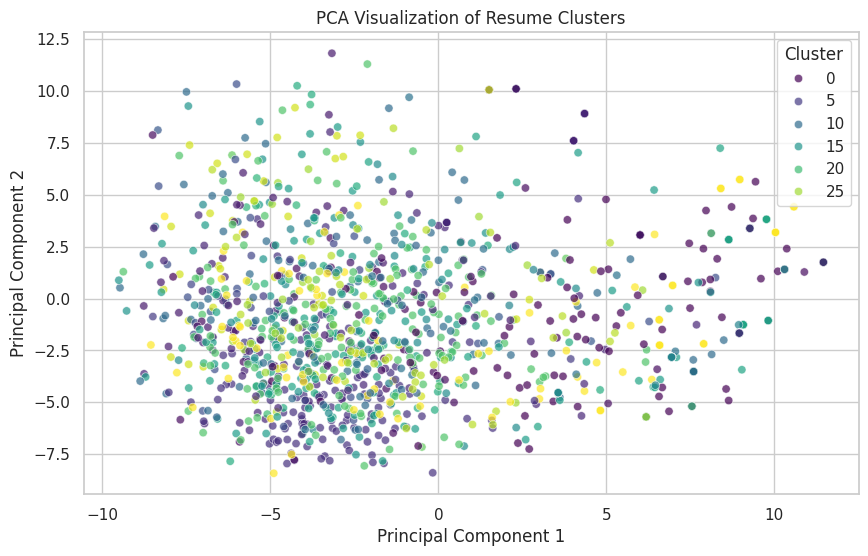

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

# Convert to DataFrame
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster"] = df["Cluster"]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=pca_df, palette="viridis", alpha=0.7)
plt.title("PCA Visualization of Resume Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()


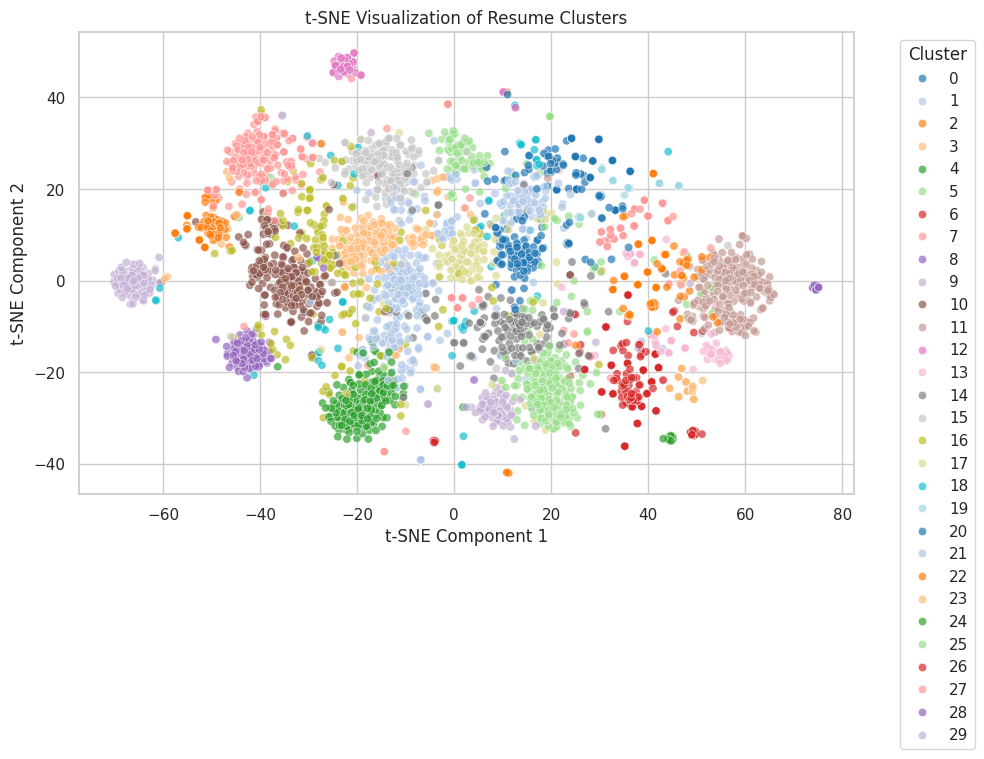

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X_np.toarray())

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["Cluster"], palette="tab20", alpha=0.7)
plt.title("t-SNE Visualization of Resume Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<ipython-input-40-735dee54195d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dbscan_cluster"] = labels


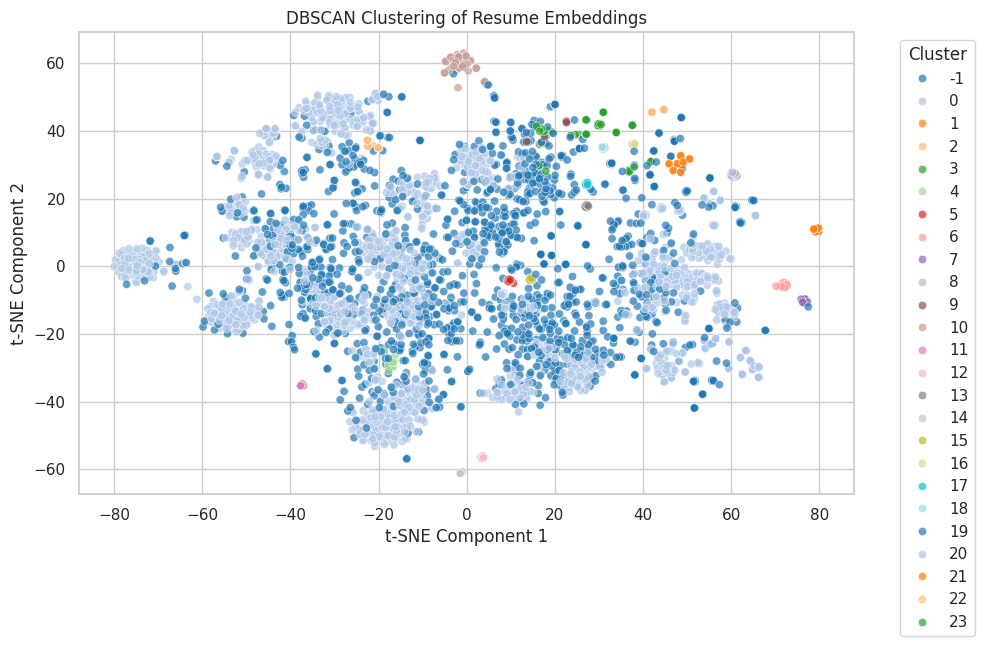

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10, metric="cosine")
labels = dbscan.fit_predict(X_np)

# Save clusters to DataFrame
df["dbscan_cluster"] = labels

# Reduce to 2D using t-SNE for visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_np.toarray())

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=df["dbscan_cluster"], palette="tab20", alpha=0.7
)
plt.title("DBSCAN Clustering of Resume Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<ipython-input-43-d487dd13717e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["agg_cluster"] = labels


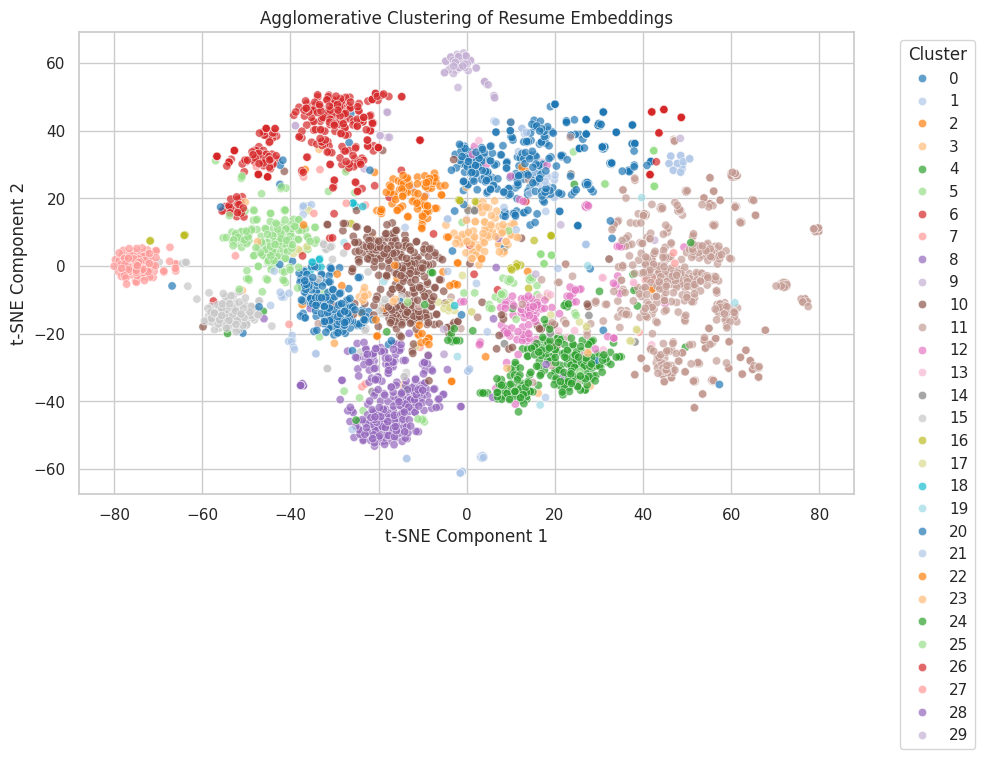

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=30, metric="cosine", linkage="average")
labels = agg_clustering.fit_predict(X_np.toarray())

df["agg_cluster"] = labels

# Visualize using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_np.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["agg_cluster"], palette="tab20", alpha=0.7)
plt.title("Agglomerative Clustering of Resume Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<ipython-input-44-879f93d350e6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["gmm_cluster"] = labels


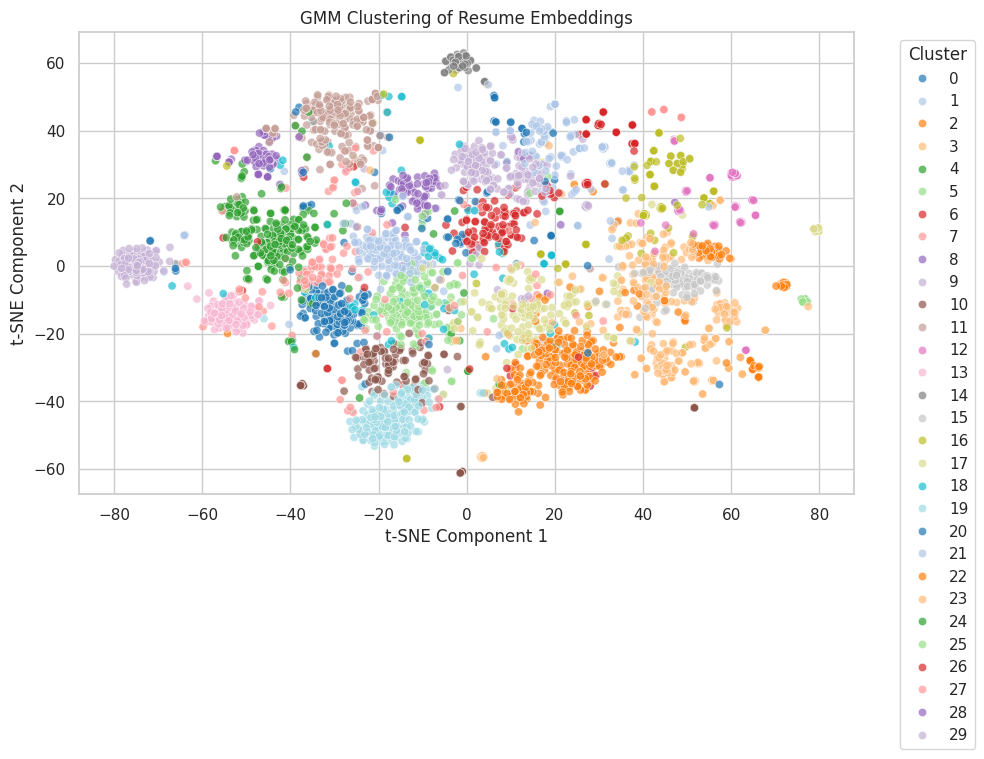

In [ ]:
from sklearn.mixture import GaussianMixture

# Fit GMM
gmm = GaussianMixture(n_components=30, covariance_type="tied", random_state=42)
labels = gmm.fit_predict(X_np.toarray())

df["gmm_cluster"] = labels

# Visualize using t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["gmm_cluster"], palette="tab20", alpha=0.7)
plt.title("GMM Clustering of Resume Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# Train model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:\n", accuracy_score(y_test, y_pred))


Classification Report:
                          precision    recall  f1-score   support

            Accountant        0.83      1.00      0.91        15
              Advocate        0.39      0.60      0.47        15
           Agriculture        0.38      0.30      0.33        10
               Apparel        0.31      0.27      0.29        15
                  Arts        0.56      0.33      0.42        15
            Automobile        0.25      0.20      0.22         5
              Aviation        0.69      0.60      0.64        15
               Banking        0.64      0.47      0.54        15
            Blockchain        1.00      1.00      1.00         6
  Business Development        1.00      0.73      0.85        15
                  Chef        1.00      0.80      0.89        15
          Construction        0.67      0.67      0.67        15
            Consultant        0.69      0.60      0.64        15
          Data Science        1.00      1.00      1.00         6


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# === Initialize Logistic Regression Model ===
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=500,
    random_state=42
)

# === Train on Balanced Training Set ===
log_reg.fit(X_train, y_train)

# === Predict on Validation Set ===
y_val_pred = log_reg.predict(X_val)

# === Evaluate ===
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Validation Accuracy: 0.6176470588235294

📊 Classification Report (Validation):
                         precision    recall  f1-score   support

            Accountant        0.83      1.00      0.91        15
              Advocate        0.53      0.67      0.59        15
           Agriculture        0.27      0.33      0.30         9
               Apparel        0.33      0.36      0.34        14
                  Arts        0.43      0.40      0.41        15
            Automobile        0.00      0.00      0.00         6
              Aviation        0.73      0.53      0.62        15
               Banking        0.60      0.40      0.48        15
            Blockchain        1.00      1.00      1.00         6
  Business Development        0.93      0.87      0.90        15
                  Chef        1.00      0.87      0.93        15
          Construction        0.88      1.00      0.94        15
            Consultant        0.88      0.47      0.61        15
        

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# === Step 1: Apply LabelEncoder to target ===
label_encoder = LabelEncoder()
y_bal_encoded = label_encoder.fit_transform(df['Category'])

# === Step 2: Apply SMOTE on full balanced dataset ===
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_np, y_bal_encoded)

# === Optional: Check new class distribution ===
print("Class Distribution After SMOTE:", Counter(y_smote))

# === Step 3: Train-test split on the new oversampled data ===
X_train, X_temp, y_train, y_temp = train_test_split(
    X_smote, y_smote, test_size=0.3, stratify=y_smote, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# === Step 4: Convert back to original labels (if needed for final prediction/report) ===
y_train_labels = label_encoder.inverse_transform(y_train)
y_val_labels = label_encoder.inverse_transform(y_val)


Class Distribution After SMOTE: Counter({np.int64(0): 100, np.int64(1): 100, np.int64(2): 100, np.int64(3): 100, np.int64(4): 100, np.int64(5): 100, np.int64(6): 100, np.int64(7): 100, np.int64(8): 100, np.int64(9): 100, np.int64(10): 100, np.int64(11): 100, np.int64(12): 100, np.int64(13): 100, np.int64(14): 100, np.int64(15): 100, np.int64(16): 100, np.int64(17): 100, np.int64(18): 100, np.int64(19): 100, np.int64(21): 100, np.int64(23): 100, np.int64(24): 100, np.int64(25): 100, np.int64(26): 100, np.int64(27): 100, np.int64(28): 100, np.int64(29): 100, np.int64(31): 100, np.int64(32): 100, np.int64(33): 100, np.int64(34): 100, np.int64(35): 100, np.int64(36): 100, np.int64(37): 100, np.int64(38): 100, np.int64(39): 100, np.int64(40): 100, np.int64(41): 100, np.int64(42): 100, np.int64(43): 100, np.int64(44): 100, np.int64(30): 100, np.int64(20): 100, np.int64(22): 100})


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# === Train XGBoost on SMOTE-balanced data ===
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_clf.fit(X_train, y_train)

# === Predict on Validation Set ===
y_val_pred = xgb_clf.predict(X_val)
y_val_pred_labels = label_encoder.inverse_transform(y_val_pred)

# === Evaluation ===
print("Validation Accuracy:", accuracy_score(y_val_labels, y_val_pred_labels))
print("\nClassification Report (Validation):")
print(classification_report(y_val_labels, y_val_pred_labels))


✅ Validation Accuracy: 0.7644444444444445

📊 Classification Report (Validation):
                         precision    recall  f1-score   support

            Accountant        0.79      1.00      0.88        15
              Advocate        0.58      0.47      0.52        15
           Agriculture        0.93      0.87      0.90        15
               Apparel        0.64      0.47      0.54        15
                  Arts        0.82      0.60      0.69        15
            Automobile        0.77      0.67      0.71        15
              Aviation        0.92      0.73      0.81        15
               Banking        0.64      0.60      0.62        15
            Blockchain        1.00      1.00      1.00        15
  Business Development        0.86      0.80      0.83        15
                  Chef        0.88      1.00      0.94        15
          Construction        0.74      0.93      0.82        15
            Consultant        0.64      0.60      0.62        15
        

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# === Predict on Test Set ===
y_test_pred_enc = xgb_clf.predict(X_test)

# === Convert Encoded Labels Back to Original Class Names ===
y_test_pred = label_encoder.inverse_transform(y_test_pred_enc)
y_test_true = label_encoder.inverse_transform(y_test)

# === Evaluate Test Set Performance ===
print("✅ Test Accuracy:", accuracy_score(y_test_true, y_test_pred))
print("\n📊 Classification Report (Test):")
print(classification_report(y_test_true, y_test_pred))


✅ Test Accuracy: 0.7540740740740741

📊 Classification Report (Test):
                         precision    recall  f1-score   support

            Accountant        0.88      0.93      0.90        15
              Advocate        0.67      0.40      0.50        15
           Agriculture        0.68      0.87      0.76        15
               Apparel        0.83      0.33      0.48        15
                  Arts        0.75      0.60      0.67        15
            Automobile        0.85      0.73      0.79        15
              Aviation        0.93      0.93      0.93        15
               Banking        0.67      0.67      0.67        15
            Blockchain        0.94      1.00      0.97        15
  Business Development        0.80      0.80      0.80        15
                  Chef        0.71      0.80      0.75        15
          Construction        0.68      1.00      0.81        15
            Consultant        0.91      0.67      0.77        15
          Data Scien

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
param_dist = {
    "max_depth": [3, 5, 6, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 5, 10],
}
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(objective="multi:softprob", num_class=len(label_encoder.classes_), eval_metric='mlogloss'),
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.7022222222222222


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

linear_svm = SVC(kernel="linear")
linear_svm.fit(X_train,y_train)
poly_svm = SVC(kernel="poly", degree=3)
poly_svm.fit(X_train,y_train)
rbf_svm = SVC(kernel="rbf",gamma="scale")
rbf_svm.fit(X_train, y_train)

linear_acc = accuracy_score(y_test,linear_svm.predict(X_test))
poly_acc = accuracy_score(y_test,poly_svm.predict(X_test))
rbf_acc = accuracy_score(y_test,rbf_svm.predict(X_test))

print("Linear SVM Accuracy:", linear_acc)
print("Polynomial SVM Accuracy:", poly_acc)
print("RBF SVM Accuracy:", rbf_acc)



Linear SVM Accuracy: 0.24202073592193535
Polynomial SVM Accuracy: 0.2425289693027038
RBF SVM Accuracy: 0.24222402927424272
